In [2]:
import torch
import json
import h5py
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import distance

In [3]:
image_file = json.load(open('/home/ace14550vm/Comic-SGG/datasets/vg/image_data.json'))
vocab_file = json.load(open('/home/ace14550vm/Comic-SGG/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File('/home/ace14550vm/Comic-SGG/datasets/vg/VG-SGG-with-attri.h5', 'r')

In [5]:
# load detected results
detected_origin_path = '/home/ace14550vm/checkpoints/lovehina/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_attri_path = '/home/ace14550vm/checkpoints/lovehina/inference/VG_stanford_filtered_with_attribute_test/'
detected_attri_result = torch.load(detected_attri_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_attri_path + 'visual_info.json'))

In [30]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = prediction.bbox
    # attributes
    attributes = prediction.get_field('attributes')[:,0].tolist()
    
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(int(i))]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores')
    
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    
#     mask = pred_rel_score > thres
#     pred_rel_score = pred_rel_score[mask]
#     pred_rel_label = pred_rel_label[mask]

    pred_rels = [(pred_labels[int(i[0])], idx2pred[str(j)], pred_labels[int(i[1])]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist()) if j!=0]
    return img_path, boxes, attributes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [78]:
font = ImageFont.truetype('/home/ace14550vm/Comic-SGG/visualization/NotoSansJP-Bold.otf', 20)

def draw_image(pic, boxes, labels, gt_rels, color='green'):
    draw = ImageDraw.Draw(pic)
    for item in gt_rels:
        sub_idx = labels.index(item[0])
        sub_box = boxes[sub_idx]
        x1,y1,x2,y2 = int(sub_box[0]), int(sub_box[1]), int(sub_box[2]), int(sub_box[3])
        sub_x = (x1 + x2) / 2
        sub_y = (y1 + y2) / 2
        draw.rectangle(((x1, y1), (x2, y2)), outline=color)
        text_width, text_height = font.getsize(item[0])
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill=color)
        draw.text((x1, y1-text_height), item[0], font=font)
        
        obj_idx = labels.index(item[2])
        obj_box = boxes[obj_idx]
        x1,y1,x2,y2 = int(obj_box[0]), int(obj_box[1]), int(obj_box[2]), int(obj_box[3])
        obj_x = (x1 + x2) / 2
        obj_y = (y1 + y2) / 2
        draw.rectangle(((x1, y1), (x2, y2)), outline=color)
        text_width, text_height = font.getsize(item[2])
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill=color)
        draw.text((x1, y1-text_height), item[2], font=font)
        
        shape = [(sub_x,sub_y),(obj_x,obj_y)]
        draw.line(shape, fill=color, width=3)
        
def draw_pred(pic, boxes, labels, pred_labels_correct, pred_rels, pred_correct):
    draw = ImageDraw.Draw(pic)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        box = boxes[i]     
        if info in pred_labels_correct:
            color='green'
        else:
            color='red'
            
        x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        draw.rectangle(((x1, y1), (x2, y2)), outline=color)
        text_width, text_height = font.getsize(info)
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill=color)
        draw.text((x1, y1-text_height), info, font=font)
        
    for item in pred_rels:
        sub_idx = labels.index(item[0])
        sub_box = boxes[sub_idx]
        sub_x1, sub_y1, sub_x2, sub_y2 = int(sub_box[0]), int(sub_box[1]), int(sub_box[2]), int(sub_box[3])
        sub_x = (sub_x1 + sub_x2) / 2
        sub_y = (sub_y1 + sub_y2) / 2
        obj_idx = labels.index(item[2])
        obj_box = boxes[obj_idx]
        obj_x1, obj_y1, obj_x2, obj_y2 = int(obj_box[0]), int(obj_box[1]), int(obj_box[2]), int(obj_box[3])
        obj_x = (obj_x1 + obj_x2) / 2
        obj_y = (obj_y1 + obj_y2) / 2
        if item in pred_correct:
            color = 'green'
        else:
            color = 'red'
            draw.rectangle(((sub_x1, sub_y1), (sub_x2, sub_y2)), outline=color)
            text_width, text_height = font.getsize(item[0])
            draw.rectangle(((sub_x1, sub_y1-text_height), (sub_x1+text_width, sub_y1)), fill=color)
            draw.text((sub_x1, sub_y1-text_height), item[0], font=font)
            
            draw.rectangle(((obj_x1, obj_y1), (obj_x2, obj_y2)), outline=color)
            text_width, text_height = font.getsize(item[2])
            draw.rectangle(((obj_x1, obj_y1-text_height), (obj_x1+text_width, obj_y1)), fill=color)
            draw.text((obj_x1, obj_y1-text_height), item[2], font=font)
        
        shape = [(sub_x,sub_y),(obj_x,obj_y)]
        draw.line(shape, fill=color, width=3)
        
        
def draw_diff(pic, boxes, labels, pred_rels, pred_different, char_coords):
    draw = ImageDraw.Draw(pic)
    for item in pred_different:
        sub_idx = labels.index(item[0])
        sub_box = boxes[sub_idx]
        x1,y1,x2,y2 = int(sub_box[0]), int(sub_box[1]), int(sub_box[2]), int(sub_box[3])
        sub_x = (x1 + x2) / 2
        sub_y = (y1 + y2) / 2
        draw.rectangle(((x1, y1), (x2, y2)), outline='green')
        text_width, text_height = font.getsize(item[0])
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill='green')
        draw.text((x1, y1-text_height), item[0], font=font)
        obj_idx = labels.index(item[2])
        obj_box = boxes[obj_idx]
        x1,y1,x2,y2 = int(obj_box[0]), int(obj_box[1]), int(obj_box[2]), int(obj_box[3])
        obj_x = (x1 + x2) / 2
        obj_y = (y1 + y2) / 2
        draw.rectangle(((x1, y1), (x2, y2)), outline='green')
        text_width, text_height = font.getsize(item[2])
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill='green')
        draw.text((x1, y1-text_height), item[2], font=font)
        shape = [(sub_x,sub_y),(obj_x,obj_y)]
        draw.line(shape, fill='green', width=3)
        
        char_coord = char_coords[:,:-1].astype(float)
        text_coord = np.array([obj_x,obj_y])
        text_coord = text_coord.reshape(-1,2)
        char = char_coords[np.argmin(distance.cdist(text_coord, char_coord),axis=1)][0,-1]
        sub_idx = labels.index(char)
        sub_box = boxes[sub_idx]
        x1,y1,x2,y2 = int(sub_box[0]), int(sub_box[1]), int(sub_box[2]), int(sub_box[3])
        sub_x = (x1 + x2) / 2
        sub_y = (y1 + y2) / 2
        shortest_rel = (char[:], 'says', item[2])
        if shortest_rel in pred_rels:
            color = 'black'
        else:
            color = 'red'
        draw.rectangle(((x1, y1), (x2, y2)), outline=color)
        text_width, text_height = font.getsize(char[:])
        draw.rectangle(((x1, y1-text_height), (x1+text_width, y1)), fill=color)
        draw.text((x1, y1-text_height), char[:], font=font)
        shape = [(sub_x,sub_y),(obj_x,obj_y)]
        draw.line(shape, fill=color, width=3)
        
def print_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))

def print_pred(name, pred, scores, pred_correct):
    for i, item in enumerate(pred):
        if item in pred_correct:
            print(str(name) + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
        else:
            print('\033[31m' + str(name) + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()) + '\033[0m')
    
def print_diff(pred_rels, scores, pred_correct, pred_different):
    for i, item in enumerate(pred_rels):
        if item in pred_correct:
            if item in pred_different:
                print('\033[32mpred_rels ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()) + '\033[0m')
            else:
                print('pred_rels ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
        else:
            print('\033[31mpred_rels ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()) + '\033[0m')

def rule_based(boxes, attributes, pred_labels, text_list, frame_dis=True):
    char_coords = np.array([])
    text_coords = np.array([])
    dis_rels = []
    
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        box = boxes[i]
        pred_label = pred_labels[i]
        attribute = attributes[i]

        x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2

        if 'character' in pred_label:
            char_coords = np.append(char_coords,[x_center,y_center,attribute,pred_label])
        if 'text' in pred_label and pred_label in text_list:
            text_coords = np.append(text_coords,[x_center,y_center,attribute,pred_label])

    char_coords = char_coords.reshape(-1,4)
    text_coords = text_coords.reshape(-1,4)

    for text in text_coords:
        frame_order = text[2]
        # find charactor in the same frame
        if frame_dis and frame_order != 0:
            char_tmp = char_coords[char_coords[:,2]==frame_order,:]
            if len(char_tmp) == 0:
                char_tmp = char_coords
        else:
            char_tmp = char_coords

        char_coord = char_tmp[:,:-2].astype(float)
        text_coord = text[np.newaxis,:-2].astype(float)

        # speaker prediction
        char = char_tmp[np.argmin(distance.cdist(text_coord, char_coord),axis=1)][0,:]
        dis_rels.append((char[-1], 'says', text[-1]))
    return dis_rels
            
def show_gt(img_path, boxes, attributes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label):
    pic = Image.open(img_path)
    draw_image(pic, boxes, labels, gt_rels)
    display(pic)
    print('*' * 50)
#     print_list('gt_boxes', labels, None)
#     print('*' * 50)
    print_list('gt_rels', gt_rels, None)
    print('*' * 50)

#     return None

def show_pred(img_path, boxes, attributes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label):
    pred_labels_correct = list(set(labels).intersection(set(pred_labels)))
    # select prediction that can cover all texts
    # text_list = [label for label in labels if 'text' in label]
    text_list = [gt_rel[2] for gt_rel in gt_rels]   # multiple speakers
    pred_list = [pred_rel[2] for pred_rel in pred_rels]
    indices = []
    for text in text_list:
        try:
            if pred_list.index(text) in indices:
                pred_list[pred_list.index(text)] = None
            indices.append(pred_list.index(text))
        except:
            pass
    pred_rels = [pred_rels[index] for index in indices]
    pred_correct = list(set(gt_rels).intersection(set(pred_rels)))  
    
    pic = Image.open(img_path)
    draw_pred(pic, boxes, labels, pred_labels_correct, pred_rels, pred_correct)
    display(pic)
    print('*' * 50)
    print_pred('pred_labels', pred_labels, pred_scores, pred_labels_correct)
    print('*' * 50)
    print_list('gt_rels', gt_rels, None)
    print('*' * 50)
    print_pred('pred_rels', pred_rels, pred_rel_score[indices], pred_correct)
    print('*' * 50) 

def show_rule(img_path, boxes, attributes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label):
    pred_labels_correct = list(set(labels).intersection(set(pred_labels)))
    # select prediction that can cover all texts
    text_list = [gt_rel[2] for gt_rel in gt_rels]   # multiple speakers
    pred_list = [pred_rel[2] for pred_rel in pred_rels]
    indices = []
    for text in text_list:
        try:
            if pred_list.index(text) in indices:
                pred_list[pred_list.index(text)] = None
            indices.append(pred_list.index(text))
        except:
            pass
    pred_rels = [pred_rels[index] for index in indices]
    pred_correct_attri = list(set(gt_rels).intersection(set(pred_rels)))  
    
    # make prediction by distance
    dis_rels = rule_based(boxes, attributes, pred_labels, text_list, frame_dis=True)
    pred_correct = list(set(gt_rels).intersection(set(dis_rels)))
    pred_different = list(set(pred_correct_attri).difference(set(pred_correct)))
    pic = Image.open(img_path)
    draw_pred(pic, boxes, labels, pred_labels_correct, pred_rels, pred_correct)
    display(pic)
    print('*' * 50)
    print_diff(pred_rels, pred_rel_score, pred_correct_attri, pred_different)
    print('*' * 50)

In [79]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
#         show_gt(*get_info_by_idx(select_idx, detected_attri_result))
#         show_rule(*get_info_by_idx(select_idx, detected_attri_result))
#         show_pred(*get_info_by_idx(select_idx, detected_origin_result))
        show_pred(*get_info_by_idx(select_idx, detected_attri_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        show_gt(*get_info_by_idx(cand_idx, detected_origin_result))
        show_pred(*get_info_by_idx(cand_idx, detected_origin_result))

108


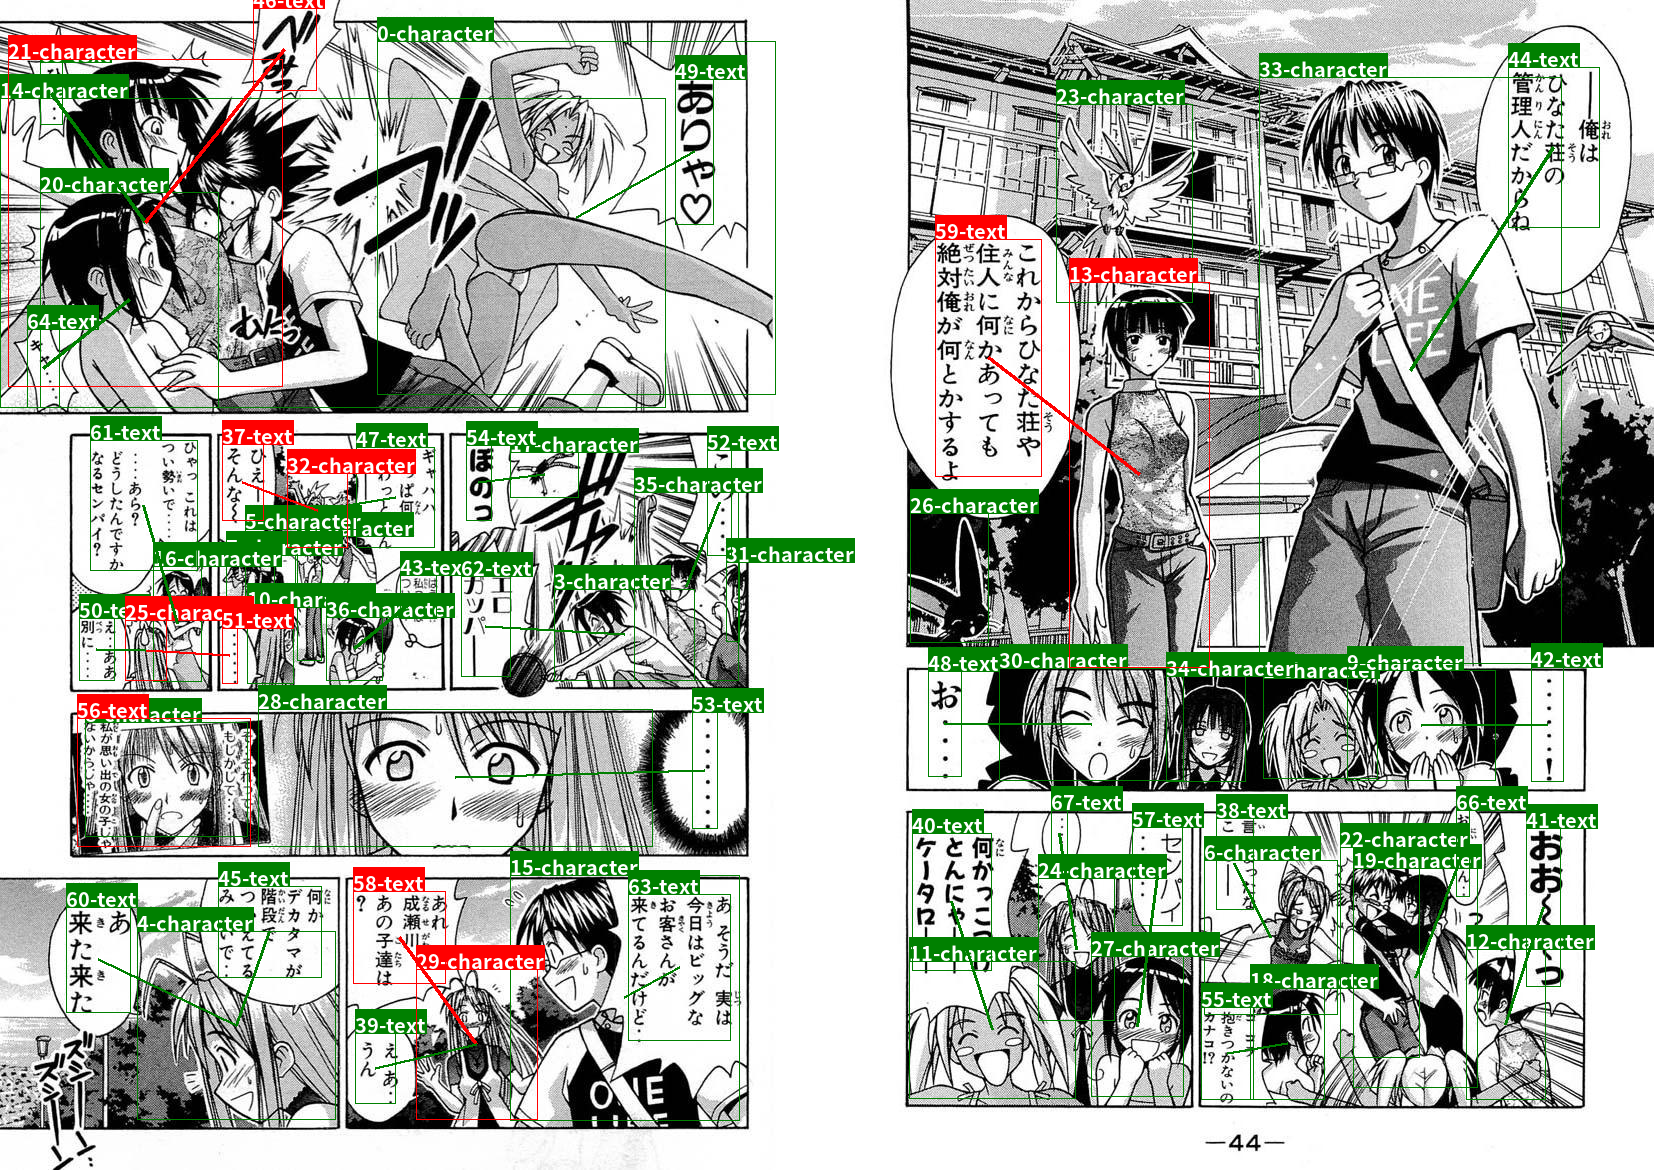

**************************************************
pred_labels 0: 0-character; score: 0.9999973773956299
pred_labels 1: 1-character; score: 0.9999998807907104
pred_labels 2: 2-character; score: 0.9999997615814209
pred_labels 3: 3-character; score: 0.9999998807907104
pred_labels 4: 4-character; score: 1.0
pred_labels 5: 5-character; score: 0.9998983144760132
pred_labels 6: 6-character; score: 1.0
pred_labels 7: 7-character; score: 0.999985933303833
pred_labels 8: 8-character; score: 0.9998866319656372
pred_labels 9: 9-character; score: 0.9999998807907104
pred_labels 10: 10-character; score: 1.0
pred_labels 11: 11-character; score: 1.0
pred_labels 12: 12-character; score: 1.0
pred_labels 13: 13-character; score: 0.9999953508377075
pred_labels 14: 14-character; score: 0.9999994039535522
pred_labels 15: 15-character; score: 0.9999980926513672
pred_labels 16: 16-character; score: 1.0
pred_labels 17: 17-character; score: 1.0
pred_labels 18: 18-character; score: 0.9999998807907104
pred_labels

In [82]:
# show_all(start_idx=1028, length=1)
show_selected([108])